1. 기초 CNN

In [ ]:
!pip install tensorflow

In [ ]:
# CNN 기반 음성 감정 분류 모델 (Angry, Happy, Neutral, Sad, Surprised)

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. 데이터 경로 및 감정 목록 설정
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/Emotions"
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]

# 라벨 인덱싱
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. Feature 추출 함수 (Mel Spectrogram)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        if mel_db.shape[1] < 128:
            mel_db = np.pad(mel_db, ((0, 0), (0, 128 - mel_db.shape[1])), mode='constant')
        else:
            mel_db = mel_db[:, :128]
        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 3. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(emotion)

# X, y 확인
print("총 수집된 샘플 수:", len(X))
print("감정 분포:", pd.Series(y).value_counts())

# 배열 변환 및 정규화
X = np.array(X)
X = X[..., np.newaxis]  # CNN을 위한 채널 차원 추가

# 라벨 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

# 4. 데이터 분할 (stratify 사용)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. CNN 모델 정의
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(target_emotions), activation='softmax')
])

# 6. 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.1)

# 7. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


Mounted at /content/drive
총 수집된 샘플 수: 8296
감정 분포: Angry      2167
Happy      2167
Sad        2167
Neutral    1795
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.2520 - loss: 9.1888 - val_accuracy: 0.2666 - val_loss: 1.6040
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2596 - loss: 1.6027 - val_accuracy: 0.2666 - val_loss: 1.5984
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2636 - loss: 1.5971 - val_accuracy: 0.2666 - val_loss: 1.5929
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2460 - loss: 1.5918 - val_accuracy: 0.2666 - val_loss: 1.5876
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2604 - loss: 1.5868 - val_accuracy: 0.2666 - val_loss: 1.5825
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2683 - loss: 1.5815 - val_accuracy: 0.2455 - val_loss: 1.5776
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2595 - loss: 1.5774 - val_accuracy: 0.2455 - val_loss: 1.5728
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2576 - loss: 1.5719 - val_acc

2. 개선된 CNN: 클래스 불균형 보정(class_weight 사용), 입력 및 배치 정규화(BatchNormalization 사용), 학습 자료에 적합하도록 CNN 구조 개선(Dropout, 필터 수를 조정하고 ReduceLROnPlateau, EarlyStopping 도입)

In [ ]:
# 개선된 CNN 기반 음성 감정 분류 모델 (정확도 향상 목적)

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 데이터 경로 및 감정 목록 설정
base_dir = "/content/drive/MyDrive/Emotions"  # 실제 경로로 수정 필요
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. Feature 추출 함수 (Mel Spectrogram + 정규화)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
        mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)  # 표준화
        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 3. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(emotion)

# 배열 변환 및 라벨 처리
X = np.array(X)
X = X[..., np.newaxis]  # CNN용 채널 추가

# 라벨 인코딩 → 배열로 변환 보장
le = LabelEncoder()
y_encoded = np.array(le.fit_transform(y))  # 여기를 꼭 numpy array로!
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4. 개선된 CNN 모델 정의
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(target_emotions), activation='softmax')
])

# 5. 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=callbacks
)

# 6. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


<ipython-input-2-f0c4723f075e>:29: RuntimeWarning: invalid value encountered in divide
  mel_db = (mel_db - np.mean(mel_db)) / np.std(mel_db)  # 표준화
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4126 - loss: 1.7404 - val_accuracy: 0.2334 - val_loss: 3.8058 - learning_rate: 5.0000e-05
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5565 - loss: 0.9715 - val_accuracy: 0.3976 - val_loss: 1.9421 - learning_rate: 5.0000e-05
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6154 - loss: 0.8942 - val_accuracy: 0.5617 - val_loss: 0.9744 - learning_rate: 5.0000e-05
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6274 - loss: 0.8590 - val_accuracy: 0.6310 - val_loss: 0.8263 - learning_rate: 5.0000e-05
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6770 - loss: 0.7599 - val_accuracy: 0.6702 - val_loss: 0.7529 - learning_rate: 5.0000e-05
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6724 - loss: 0.7433 - val_accuracy: 0.6822 - val_loss: 0.7685 - learning_rate: 5.0000e-05
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - ac

3. 단일 LSTM 레이어 + Dense 구조 사용

In [ ]:
# 개선된 LSTM 기반 음성 감정 분류 모델

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 데이터 경로 및 감정 목록 설정
base_dir = "/content/drive/MyDrive/Emotions"  # 실제 경로로 수정 필요
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. Feature 추출 함수 (MFCC + 정규화)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc = librosa.util.fix_length(mfcc, size=128, axis=1)
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
        return mfcc.T  # (128, 40)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 3. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(emotion)

# 배열 변환 및 라벨 처리
X = np.array(X)  # shape: (samples, 128, 40)

le = LabelEncoder()
y_encoded = np.array(le.fit_transform(y))
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4. LSTM 모델 정의
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(128, 40)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_emotions), activation='softmax')
])

# 5. 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=callbacks
)

# 6. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2409 - loss: 2.1483 - val_accuracy: 0.3102 - val_loss: 1.5267 - learning_rate: 5.0000e-05
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2649 - loss: 1.8370 - val_accuracy: 0.3238 - val_loss: 1.4375 - learning_rate: 5.0000e-05
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2591 - loss: 1.7827 - val_accuracy: 0.3238 - val_loss: 1.3820 - learning_rate: 5.0000e-05
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2756 - loss: 1.7048 - val_accuracy: 0.3705 - val_loss: 1.3316 - learning_rate: 5.0000e-05
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3006 - loss: 1.6080 - val_accuracy: 0.4247 - val_loss: 1.2625 - learning_rate: 5.0000e-05
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3456 - loss: 1.4905 - val_accuracy: 0.5000 - val_loss: 1.0880 - learning_rate: 5.0000e-05
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc

4. CNN+LSTM 하이브리드 모델(Conv1D+MaxPooling1D로 음향 패턴 추출, LSTM으로 시간 흐름 정보 분석, BatchNormalization+Dropout으로 일반화 성능 향상)

In [ ]:
# CNN+LSTM 하이브리드 기반 음성 감정 분류 모델

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 데이터 경로 및 감정 목록 설정
base_dir = "/content/drive/MyDrive/Emotions"  # 실제 경로로 수정 필요
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. Feature 추출 함수 (MFCC + 정규화)
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc = librosa.util.fix_length(mfcc, size=128, axis=1)
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
        return mfcc.T  # shape: (128, 40)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 3. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(emotion)

X = np.array(X)  # shape: (samples, 128, 40)

le = LabelEncoder()
y_encoded = np.array(le.fit_transform(y))
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 4. CNN+LSTM 하이브리드 모델 정의
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(128, 40)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_emotions), activation='softmax')
])

# 5. 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=callbacks
)

# 6. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2439 - loss: 2.4122 - val_accuracy: 0.2651 - val_loss: 1.4960 - learning_rate: 5.0000e-05
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2681 - loss: 1.9751 - val_accuracy: 0.3163 - val_loss: 1.4636 - learning_rate: 5.0000e-05
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2938 - loss: 1.7768 - val_accuracy: 0.3087 - val_loss: 1.4350 - learning_rate: 5.0000e-05
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2865 - loss: 1.7575 - val_accuracy: 0.3479 - val_loss: 1.3787 - learning_rate: 5.0000e-05
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2988 - loss: 1.6923 - val_accuracy: 0.3569 - val_loss: 1.3588 - learning_rate: 5.0000e-05
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3146 - loss: 1.6411 - val_accuracy: 0.3705 - val_loss: 1.3323 - learning_rate: 5.0000e-05
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc

In [ ]:
# 고급 CNN + BiLSTM + 데이터 증강 기반 감정 분류 모델

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 데이터 경로 및 감정 목록 설정
base_dir = "/content/drive/MyDrive/Emotions"  # 실제 경로로 수정 필요
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. 데이터 증강 함수 (속도 조절 + 피치 이동)
def augment_audio(y, sr):
    if np.random.rand() < 0.5:
        y = librosa.effects.time_stretch(y, rate=0.9 + 0.2 * np.random.rand())
    if np.random.rand() < 0.5:
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=np.random.randint(-2, 3))  # 수정된 부분
    return y

# 3. Feature 추출 함수 (MFCC + MEL 병합 + 정규화)
def extract_features(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        if augment:
            y = augment_audio(y, sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20)
        mel_db = librosa.power_to_db(mel)
        features = np.vstack([mfcc, mel_db])  # (40, time)
        features = librosa.util.fix_length(features, size=128, axis=1)
        features = (features - np.mean(features)) / np.std(features)
        return features.T  # shape: (128, 40)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 4. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                # 원본 + 증강본 모두 추가
                for aug in [False, True]:
                    features = extract_features(file_path, augment=aug)
                    if features is not None:
                        X.append(features)
                        y.append(emotion)

X = np.array(X)

le = LabelEncoder()
y_encoded = np.array(le.fit_transform(y))
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. CNN + BiLSTM 모델 정의
model = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(128, 40)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=True)),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_emotions), activation='softmax')
])

# 6. 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=60,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=callbacks
)

# 7. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2364 - loss: 2.0174 - val_accuracy: 0.4224 - val_loss: 1.3514 - learning_rate: 5.0000e-05
Epoch 2/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.3373 - loss: 1.6327 - val_accuracy: 0.5098 - val_loss: 1.1068 - learning_rate: 5.0000e-05
Epoch 3/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4126 - loss: 1.4026 - val_accuracy: 0.5640 - val_loss: 1.0439 - learning_rate: 5.0000e-05
Epoch 4/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4799 - loss: 1.2439 - val_accuracy: 0.5956 - val_loss: 0.9292 - learning_rate: 5.0000e-05
Epoch 5/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5047 - loss: 1.1502 - val_accuracy: 0.6220 - val_loss: 0.9151 - learning_rate: 5.0000e-05
Epoch 6/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5293 - loss: 1.0820 - val_accuracy: 0.6152 - val_loss: 0.9209 - learning_rate: 5.0000e-05
Epoch 7/60
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - ac

5. 고급화 CNN+LSTM 모델(pitch shift, time stretch로 데이터 증강/ MFCC+Mel-spectrogram을 결합하여 더 풍부한 입력 생성/ BiLSTM+LSTM 스택 사용으로 시계열 정보 양방향 학습/ BatchNormalization+Dropout/ EarlyStopping 및 ReduceLROnPlateau 콜백) = 약 83% - 2차 수정(데이터 추가 증강, Attention 메커니즘으로 고조된 감정 순간에 집중, Cosine LearningRate 사용) = 약 91%

In [ ]:
# 고급 CNN + BiLSTM + Cosine LR + 데이터 증강 + Attention 기반 감정 분류 모델

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# 1. 데이터 경로 및 감정 목록 설정
base_dir = "/content/drive/MyDrive/Emotions"  # 실제 경로로 수정 필요
target_emotions = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]
label_map = {emotion: i for i, emotion in enumerate(target_emotions)}

# 2. 데이터 증강 함수 (속도 조절 + 피치 이동)
def augment_audio(y, sr):
    if np.random.rand() < 0.5:
        y = librosa.effects.time_stretch(y, rate=0.9 + 0.2 * np.random.rand())
    if np.random.rand() < 0.5:
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=np.random.randint(-2, 3))
    return y

# 3. Feature 추출 함수 (MFCC + MEL 병합 + 정규화)
def extract_features(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        if augment:
            y = augment_audio(y, sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20)
        mel_db = librosa.power_to_db(mel)
        features = np.vstack([mfcc, mel_db])  # (40, time)
        features = librosa.util.fix_length(features, size=128, axis=1)
        features = (features - np.mean(features)) / np.std(features)
        return features.T  # shape: (128, 40)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 4. 데이터 로딩 및 전처리
X = []
y = []

for emotion in target_emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.exists(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file)
                for aug in [False, True]:
                    features = extract_features(file_path, augment=aug)
                    if features is not None:
                        X.append(features)
                        y.append(emotion)

# ✅ Emo-DB 파일 추가
emo_map = {
    'W': 'angry',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fearful',
    'F': 'happy',
    'T': 'sad',
    'N': 'neutral'
}

emodb_path = "/content/drive/MyDrive/wav"

for file in os.listdir(emodb_path):
    if file.endswith(".wav") and len(file) >= 6:
        code = file[5]  # 6번째 문자로 감정 코드 추출
        emotion = emo_map.get(code)
        if emotion in target_emotions:  # 기존 모델 감정들과 일치하는 경우만 추가
            full_path = os.path.join(emodb_path, file)
            for aug in [False, True]:  # 기존 증강 전략과 통일
                features = extract_features(full_path, augment=aug)
                if features is not None:
                    X.append(features)
                    y.append(emotion)

X = np.array(X)
le = LabelEncoder()
y_encoded = np.array(le.fit_transform(y))
y_cat = to_categorical(y_encoded, num_classes=len(target_emotions))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. CNN + BiLSTM + Attention 모델 정의
inputs = Input(shape=(128, 40))
x = Conv1D(128, kernel_size=5, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(64, return_sequences=True)(x)
attn = Attention()([x, x])
x = GlobalAveragePooling1D()(attn)

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(target_emotions), activation='softmax')(x)

model = Model(inputs, outputs)

# 6. Cosine learning rate + 컴파일 및 학습
cosine_lr = CosineDecayRestarts(initial_learning_rate=0.0005, first_decay_steps=10)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=cosine_lr), metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True)
]

model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=60,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=callbacks
)

# 7. 평가
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])

# 8. 모델 저장
model.save('/content/drive/MyDrive/emotion_model.keras')

Epoch 1/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.5513 - loss: 1.0614 - val_accuracy: 0.6867 - val_loss: 0.7615
Epoch 2/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7045 - loss: 0.7229 - val_accuracy: 0.7264 - val_loss: 0.6506
Epoch 3/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7437 - loss: 0.6185 - val_accuracy: 0.7835 - val_loss: 0.5181
Epoch 4/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7788 - loss: 0.5470 - val_accuracy: 0.7454 - val_loss: 0.6285
Epoch 5/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7780 - loss: 0.5642 - val_accuracy: 0.8049 - val_loss: 0.4629
Epoch 6/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8101 - loss: 0.4811 - val_accuracy: 0.8239 - val_loss: 0.4237
Epoch 7/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8371 - loss: 0.4235 - val_accuracy: 0.7576 - val_loss: 0.6354
Epoch 8/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7914 - loss: 0.5305 - val

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 39.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 124, 128)  │     25,728 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 124, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 62, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 62, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 62, 256)   │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 62, 64)    │     82,176 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 62, 64)    │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        325 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 376,325 (1.44 MB)

 Trainable params: 375,941 (1.43 MB)

 Non-trainable params: 384 (1.50 KB)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 96.3MiB/s]



=== [Korean_angry] /content/drive/MyDrive/Test_Emotions/Angry/angry_kor.wav ===



Transcription ▶ 아니 요즘 멘트 아 외르는 것이 이해가 안되네 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


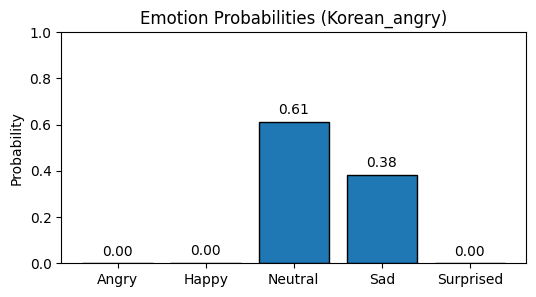


=== [Korean_happy] /content/drive/MyDrive/Test_Emotions/Happy/happy_kor2.wav ===



Transcription ▶ 왜? 프로젝트 최종 발표가 끝났어. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


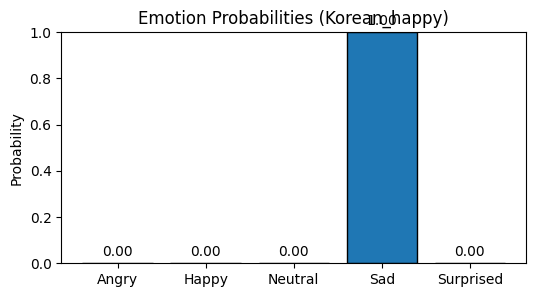


=== [Korean_neutral] /content/drive/MyDrive/Test_Emotions/Neutral/neutral_kor.wav ===



Transcription ▶ 나 내일 친구랑 약속 있는데 뭘 모아야 될지 고민이야. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


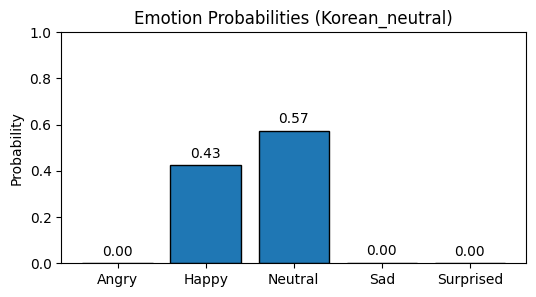


=== [Korean_sad] /content/drive/MyDrive/Test_Emotions/Sad/sad_kor.wav ===



Transcription ▶ 600원 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


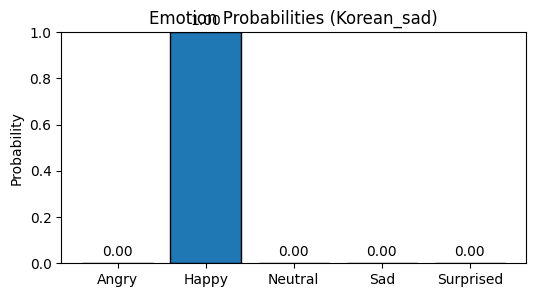


=== [Korean_surprised] /content/drive/MyDrive/Test_Emotions/Surprised/surprised_kor1.wav ===



Transcription ▶ 실제로는 폭탄이 터지는 게 아니라 그냥 청전 소리였어 그 소리가 그렇게 크게 들리더라고 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


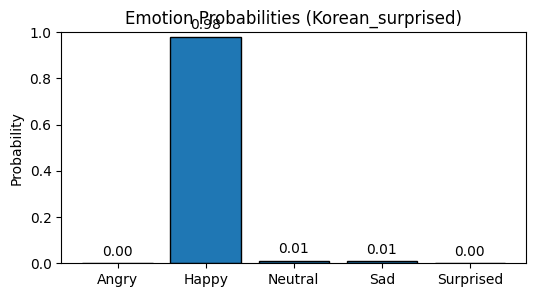


=== [English_angry] /content/drive/MyDrive/Test_Emotions/Angry/angry_eng.wav ===



Transcription ▶ Kids are talking by the door! 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


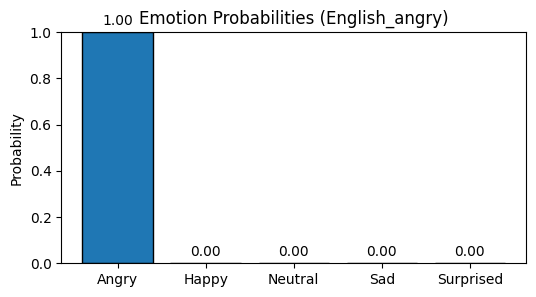


=== [English_happy] /content/drive/MyDrive/Test_Emotions/Happy/happy_eng.wav ===



Transcription ▶ Kids are talking by the door. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


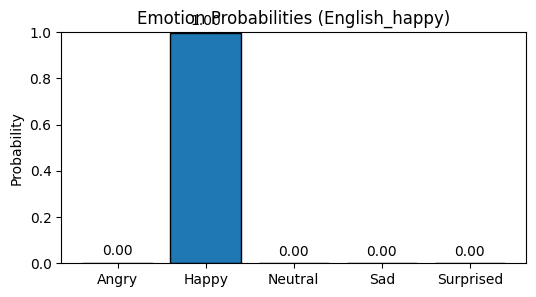


=== [English_neutral] /content/drive/MyDrive/Test_Emotions/Neutral/neutral_eng.wav ===



Transcription ▶ Kids are talking by the door. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


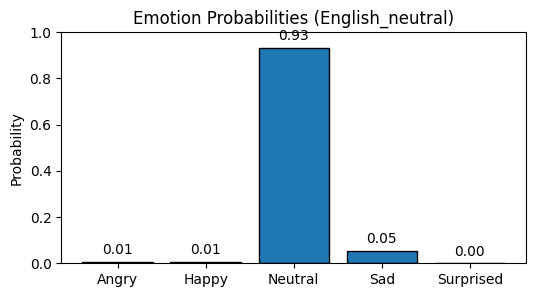


=== [English_sad] /content/drive/MyDrive/Test_Emotions/Sad/sad_eng.wav ===



Transcription ▶ Kids are talking by the door. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


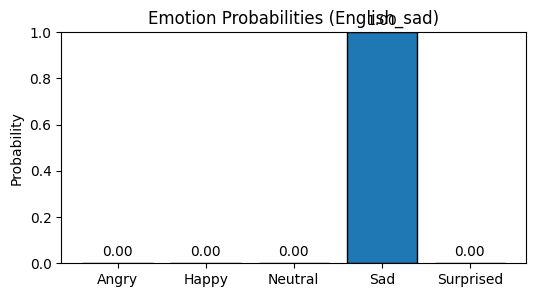


=== [English_surprised] /content/drive/MyDrive/Test_Emotions/Surprised/surprised_eng.wav ===



Transcription ▶ Kids are talking by the door. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


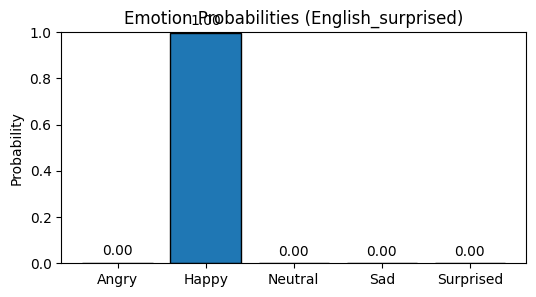


=== [German_angry] /content/drive/MyDrive/Test_Emotions/Angry/angry_ger.wav ===



Transcription ▶ Das schwarze Plat-Papier befindet sich da oben neben dem Holzstück. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


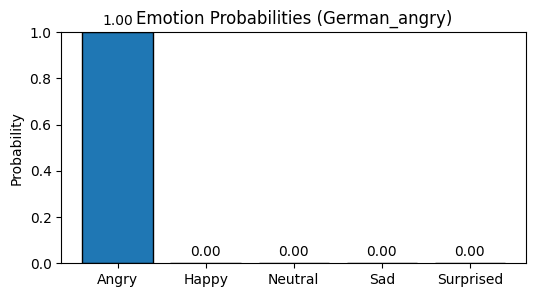


=== [German_happy] /content/drive/MyDrive/Test_Emotions/Happy/happy_ger.wav ===



Transcription ▶ Das Schwarze Blatt Papier! Wir findet sich da oben! Nehen dem Holzstück! 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


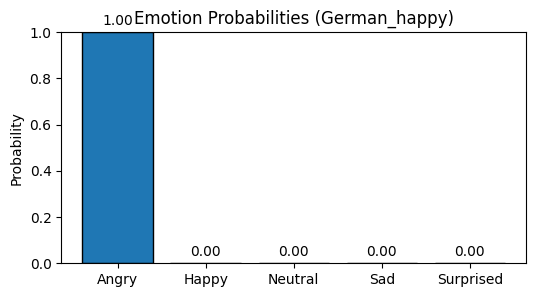


=== [German_neutral] /content/drive/MyDrive/Test_Emotions/Neutral/neutral_ger.wav ===



Transcription ▶ In sieben Stunden wird es soweit sein. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


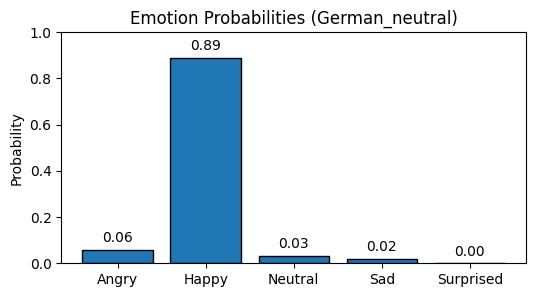


=== [German_sad] /content/drive/MyDrive/Test_Emotions/Sad/sad_ger.wav ===



Transcription ▶ Heute Abend könnte ich es ihm sagen. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


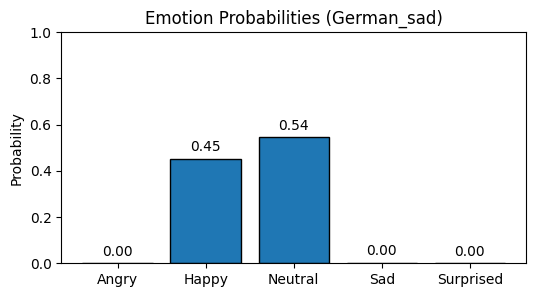

In [ ]:
# 1) 필요한 라이브러리 설치/불러오기
!pip install -q openai-whisper   # Whisper 설치

import whisper
import librosa
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# (기존) CNN 감정 분류 모델 로드
model = load_model('/content/drive/MyDrive/emotion_model.keras', compile=False)
model.summary()

def extract_mel_spectrogram(file_path, sr=22050, n_mels=40, fixed_length=128):
    y, _ = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    mel_db = librosa.util.fix_length(mel_db, size=fixed_length, axis=1)
    # (time, mel) 형태로
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)
    return mel_db.T  # (128, 40)

# 2) Whisper 모델 로드 (한 번만)
whisper_model = whisper.load_model("base")

# 3) 테스트할 파일 경로 설정 (한국어/영어/독일어)
test_files = {
    "Korean_angry": "/content/drive/MyDrive/Test_Emotions/Angry/angry_kor.wav",
    "Korean_happy": "/content/drive/MyDrive/Test_Emotions/Happy/happy_kor2.wav",
    "Korean_neutral": "/content/drive/MyDrive/Test_Emotions/Neutral/neutral_kor.wav",
    "Korean_sad": "/content/drive/MyDrive/Test_Emotions/Sad/sad_kor.wav",
    "Korean_surprised": "/content/drive/MyDrive/Test_Emotions/Surprised/surprised_kor1.wav",
    "English_angry": "/content/drive/MyDrive/Test_Emotions/Angry/angry_eng.wav",
    "English_happy": "/content/drive/MyDrive/Test_Emotions/Happy/happy_eng.wav",
    "English_neutral": "/content/drive/MyDrive/Test_Emotions/Neutral/neutral_eng.wav",
    "English_sad": "/content/drive/MyDrive/Test_Emotions/Sad/sad_eng.wav",
    "English_surprised": "/content/drive/MyDrive/Test_Emotions/Surprised/surprised_eng.wav",
    "German_angry": "/content/drive/MyDrive/Test_Emotions/Angry/angry_ger.wav",
    "German_happy": "/content/drive/MyDrive/Test_Emotions/Happy/happy_ger.wav",
    "German_neutral": "/content/drive/MyDrive/Test_Emotions/Neutral/neutral_ger.wav",
    "German_sad": "/content/drive/MyDrive/Test_Emotions/Sad/sad_ger.wav",
}

for lang, audio_path in test_files.items():
    print(f"\n=== [{lang}] {audio_path} ===\n")

    # 4) 오디오 재생
    display(Audio(filename=audio_path, autoplay=False))

    # 5) Whisper로 전사
    result = whisper_model.transcribe(audio_path, language=None)
    # language=None 이면 자동 감지, 언어 지정 가능(language="de" or "ko")
    transcript = result["text"].strip()
    print("Transcription ▶", transcript, "\n")

    # 6) 감정 예측
    feat = extract_features(audio_path)             # (128,40)
    inp  = np.expand_dims(feat, axis=0)             # (1,128,40)
    probs = model.predict(inp)[0]                   # (5,)

    # 7) Matplotlib 막대그래프 시각화
    labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']
    plt.figure(figsize=(6,3))
    bars = plt.bar(labels, probs, edgecolor='k')
    plt.title(f"Emotion Probabilities ({lang})")
    plt.ylabel("Probability")
    plt.ylim(0,1)
    # 확률값 레이블 표시
    for bar, p in zip(bars, probs):
        plt.text(bar.get_x()+bar.get_width()/2, p+0.02, f"{p:.2f}",
                 ha='center', va='bottom', fontsize=10)
    plt.show()


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive
